<span style="font-size:110%; text-align:left;"><b><a href="../index.html">2. Plane Waves</a> > <a href="./index.html">4. Demodulation</a></b></span>
<br/><br/>
<span style="font-size:200%; text-align:left;"><b>Single Demodulation</b></span>
<br/><br/>
<span style="font-size:110%; text-align:left;">Author: Daniel Töyrä </span>

<img src="files/demodulation.svg" style="width: 600px;" align="center"/>

# Table of Contents
 <p><div class="lev1"><a href="#1.-Introduction">1. Introduction</a></div><div class="lev1"><a href="#2.-Single-demodulation">2. Single demodulation</a></div><div class="lev2"><a href="#2.1.-Simulation-example">2.1. Simulation example</a></div><div class="lev1"><a href="#3.-Tasks">3. Tasks</a></div><div class="lev2"><a href="#3.1.-Reconstruct-complex-amplitude-of-a-sideband">3.1. Reconstruct complex amplitude of a sideband</a></div><div class="lev1"><a href="#4.-Tasks-with-answers">4. Tasks with answers</a></div><div class="lev2"><a href="#4.1.-Reconstruct-complex-amplitude-of-a-sideband">4.1. Reconstruct complex amplitude of a sideband</a></div><div class="lev1"><a href="#5.--Summary">5.  Summary</a></div>

# 1. Introduction

Demodulation is the technique of extracting the information modulated on the carrier. In laser interferometry, a demodulator is an electronic circuit that is applied after detecting the power of the laser beam, and it is used to extract the information about what caused the modulation in the first place. For gravitational wave detectors, it is used to extract information about the gravitational wave signal, extract noise noise information, and reading out information necessary for controlling the interferometer. 

** Recommended notebooks before you start:**

We recommend that you have looked through the notebooks that you find in the folder [02_Plane_waves/03_Optical_modulation](../03_Optical_modulation/index.html) before you start this notebook, or that you have basic experience of IPython/Jupyter Notebooks, PyKat, Finesse, and optical modulation. The link above only works if you started IPython/Jupyter Notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3). - Living review article (more like a book) on laser interferometry in the frequency domain for detecting gravitational waves, and FINESSE.

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf). - FINESSE-manual

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/) - Useful online syntax reference for FINESSE. Also available in the Finesse manual [2], but this online version is updated more frequently.

** After this session you will... **

* have used the FINESSE component `pd1` to demodulate an amplitude modulated laser field.
* have seen that by using two demodulation schemes, with demodulation phases 90 degrees shifted from each other, one can extract the full amplitude and phase of the demodulation signal.
* have seen that by measuring the DC-power as well, one can even extract the full amplitude and phase information of the process that generated the modulation.

# 2. Single demodulation

Importing PyKat and other Python packages that we need, and setting up how to display figures.

In [52]:
import numpy as np                         # Importing numpy
import matplotlib                          # For plotting
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool. Change the dpi value 
# to adjust size of figures on your screen.
pykat.init_pykat_plotting(dpi=90)          

A typical application of demodulation, is its use in a modulation-demodulation scheme. The scheme looks as follows: 

* Modulate the carrier field. This can be done by an electro-optic modulator, some noise source, a gravitational wave etc. 
* Detect the power by using a photo diode
* Demodulate the signal at a user-defined frequency $\omega_x$. This step is performed by an electronic mixer and a low-pass filter. The output is a DC-signal that is proportional to the amplitude of the carrier and the amplitude of the sidebands with frequencies $\omega_0 \pm \omega_x$, where $\omega_0$ is the carrier frequency. 


Interestingly, by using two mixers with different phase offsets one can also reconstruct the phase difference between the light at $\omega_0 \pm \omega_x$ with respect to the carrier. This feature can be very powerful for generating interferometer control signals. If you want to read more about demodulation and go through the math of it, see section 4.1-2 in the living review article [1]. Here, we jump directly into a FINESSE-example.

## 2.1. Simulation example

<img src="files/demodulation.svg" style="width: 400px;" align="center"/>

In this Finesse example a carrier field is amplitude modulated by using an electro-optic modulator (EOM) (keyword `mod`). We first build our optical model consisting of an input laser, and an EOM that amplitude modulates the carrier field on 1 kHz and with a modulation phase of 30 degrees.  We also add an empty space between the laser and the EOM, as well as after the EOM, which will soon connect the EOM with the detectors, as seen in the figure above.

In [53]:
basekat = finesse.kat()          # Initialising Finesse
basekat.verbose = False          # Tells Finesse to talk less

basecode = """
## The optical system ##

l laser 1 0 n0                # Laser (P = 1 W, Freq. offset = 0 Hz)
s s1 1 n0 n1                  # Space, laser to EOM (L = 1 m)
mod eom 1k 0.3 1 am 30 n1 n2  # Modulator (f = 1 kHz, m=0.3, 1 sideband pair, 
                              # type = amplitude modulation, phase = 30 deg.)
s s2 1n n2 n3                 # Space, EOM to output (L = 1 nm)

"""
# Parsing the FINESSE-code
basekat.parseCommands(basecode)

Now we add detectors to measure the power after the EOM. We will here use three different demodulation schemes, which we in FINESSE can put at the exact same node simultaneously. In reality we would need to use beam splitters to divide the beam up into three parts, which can easily be done in FINESSE as well, but we do not care about this here. 

The power is in all three cases measured by a photodiode. After the power is measured we demodulate the power signal on the modulation frequency of 1 kHz, and we will do this with three different demodulation phases: $\varphi_x = 0$ which we call in-phase, $\varphi_x = 90$ degrees which we call in-quadrature, and $\varphi_x = 30$ degrees, which is the  modulation phase we use. After the demodulation, or the mixing, we low pass filter our signals so that only the DC-parts remain. These three steps (photo diode + mixing + low pass filter) are performed by the components with the FINESSE components with the keyword `pd1`, where `1` stands for single demodulation. While doing these measurement, we are varying the modulation index of the EOM. 

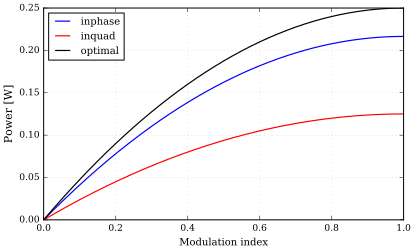

In [54]:
kat1 = basekat.deepcopy()

code = """
## Detectors ##
pd1 inphase 1k 0 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod phase = 0 deg.)
pd1 inquad 1k 90 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod. phase = 90 deg.)
pd1 optimal 1k 30 n3    # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod. phase = 30 deg.)

## Simulation Instructions ##
xaxis eom midx lin 0 1 200   # Varying EOM modulation between 0 and 1
yaxis abs                    # Returns absolute values of detector outputs
"""

# Parsing the code and running the simulation
kat1.parseCommands(code)
out1 = kat1.run()

fig1a = out1.plot(xlabel = 'Modulation index', ylabel = 'Power [W]')

The figure shows three traces with different demodulation phases $\varphi_x$. The one called in-phase has $\varphi_x = 0$ and the one called in-quadrature has $\varphi_x = \pi/2~ (=90~\mathrm{degrees})$. For the trace called optimal we used a demodulation phase equal to the the modulation phase, in this case $\varphi_x = 30$ degrees. The in-phase and the in-quadrature signals correspond to the real and imaginary part the demodulated signal $S_1$, thus by combining them according to 

\begin{align}
S_1 = S_{1,\mathrm{phase}} + iS_{1,\mathrm{quad}}~,
\end{align}

we can reconstruct the full demodulation signal $S_1$. Lets do this:

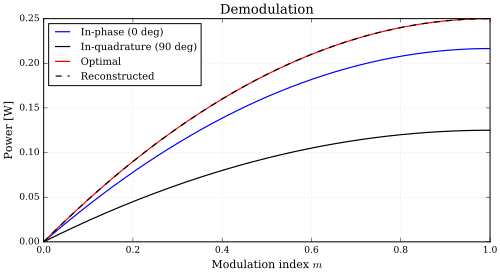

In [55]:
# Reconstructing full amplitude and phase information
tot = out1['inphase'] + 1j*out1['inquad']

## Plotting ##
fig1b = plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
ax.plot(out1.x, out1['inphase'], 'b-', label='In-phase (0 deg)')
ax.plot(out1.x, out1['inquad'], 'k-', label='In-quadrature (90 deg)')
ax.plot(out1.x, out1['optimal'], 'r-', label='Optimal')
ax.plot(out1.x, np.abs(tot), 'k--', label='Reconstructed')

ax.set_xlabel('Modulation index $m$')
ax.set_ylabel('Power [W]')
ax.set_title('Demodulation')
ax.legend(loc=0, fontsize=10)

plt.show()

We see that our reconstructed signal exactly follows the signal obtained by using the optimal demodulation phase of $\varphi_x = 30$ degrees. To explicitly show that the phase is reconstructed as well we wait until the task below to show.

In FINESSE you can always "cheat" and obtain the optimal trace by using the keyword `max` as the demodulation phase, and you can even obtain the full complex demodulation signal directly by leaving the spot for demodulation phase empty, and using `yaxis abs:deg`. 

# 3. Tasks

## 3.1. Reconstruct complex amplitude of a sideband

Reconstruct the amplitude and phase information of one of the two amplitude modulation sidebands using only realistic laboratory measurements. That is, measure the in-phase ($\varphi_x = 0$ deg) and in-quadrature ($\varphi_x = 90$ deg) as in the example above, as well as a measurement of the DC power (keyword `pd`). Use an amplitude detector to detect the complex sideband amplitude directly as a comparison to see if you are correct.

*Hint: Use the living review article [1], section 4.2, to work out a formula.*

**Answer:**

# 4. Tasks with answers

## 4.1. Reconstruct complex amplitude of a sideband

Reconstruct the amplitude and phase information of one of the two amplitude modulation sidebands using only realistic laboratory measurements. That is, measure the in-phase ($\varphi_x = 0$ deg) and in-quadrature ($\varphi_x = 90$ deg) as in the example above, as well as a measurement of the DC power (keyword `pd`). Use an amplitude detector to detect the complex sideband amplitude directly as a comparison to see if you are correct.

*Hint: Use the living review article [1], section 4.2, to work out a formula.*

**Answer:**

Using the same code as in the example above, but adding a photo diode for measuring the DC-power and an amplitude detector that measures the complex amplitude of the upper sideband. Also switching to `yaxis abs:deg` to obtain the complex amplitude of the sideband, without this change we only get the magnitude. 

In [56]:
kat2 = basekat.deepcopy()

code = """
## Detectors ##
pd1 inphase 1k 0 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod phase = 0 deg.)
pd1 inquad 1k 90 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod. phase = 90 deg.)
pd dc n3                # Photo diode + low pass filter
ad amp 1k n3            # Amplitude detector (f=1k Hz)

## Simulation Instructions ##
xaxis eom midx lin 0 1 400   # Varying EOM modulation between 0 and 1
yaxis abs:deg                # Returns absolute values of detector outputs
"""

# Parsing the code and running the simulation
kat2.parseCommands(code)
out2 = kat2.run()

The laser field after the modulator contains exactly three frequency components, as amplitude modulation always generate 1 sideband pair. From the living review article [1] we can see that the DC power (photo diode followed by a low pass filter) in our case is given by

\begin{align}
S_\mathrm{DC} = |a_0|^2 + |a_-|^2 + |a_+|^2 ~,
\end{align}

where $a_0$, $a_-$, $a_+$ are the complex amplitudes of the carrier, lower sideband, and upper sideband, respectively. We can also see that the full complex demodulation signal is given by

\begin{align}
S_1 = a_0 a_-^* + a_0^* a_+ .
\end{align}

In our case the carrier has zero frequency as long as it has not been transmitted though any surfaces (FINESSE convention), thus $a_0$ is a real number. As an effect of this $a_+ = a_-^*$, thus we can write the DC power as $S_\mathrm{DC} = |a_0|^2 + 2|a_+|^2$ and the demodulation signal as $S_1 = 2a_0 a_+$. By combining $S_\mathrm{DC}$ and $S_1$ we get

\begin{align}
a_0 = \sqrt{ \frac{S_\mathrm{DC} + \sqrt{S_\mathrm{DC}^2 - 2|S_1|^2} }{2} }
\end{align}

and

\begin{align}
a_+ = \frac{S_1}{2a_0} ~.
\end{align}

Now we are ready to use the FINESSE-output to compute the sideband amplitude.

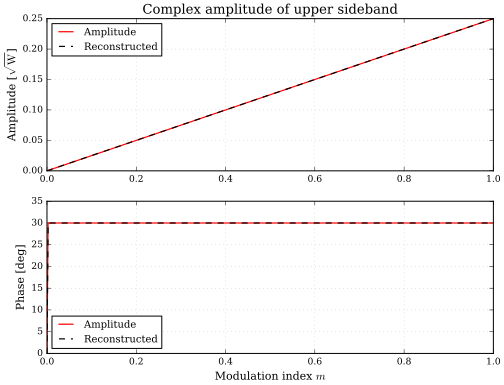

In [57]:
# Reconstructing full amplitude and phase information
S1 = out2['inphase'] + 1j*out2['inquad']

# Calculating the amplitude of the carrier
a0 = np.sqrt( ( out2['dc'] + np.sqrt(out2['dc']**2 - 2*np.abs(S1)**2) )/2 )

# Calculating complex amplitude of the upper sideband
a_plus = S1/(2*a0)

## Plotting ##

# Plotting the the absolute value
fig1b = plt.figure(figsize = (8,6))
ax = plt.subplot(2,1,1)
ax.plot(out2.x, np.abs(out2['amp']), 'r-', label='Amplitude')
ax.plot(out2.x, np.abs(a_plus), 'k--', label='Reconstructed')
ax.set_ylabel('Amplitude [$\sqrt{\mathrm{W}}$]')
ax.set_title('Complex amplitude of upper sideband')
ax.legend(loc=0, fontsize=10)

# Plotting the phase (Converting from radians to degrees)
ax2 = plt.subplot(2,1,2)
ax2.plot(out2.x, np.angle(out2['amp'])*180/np.pi, 'r-', label='Amplitude')
ax2.plot(out2.x, np.angle(a_plus)*180/np.pi, 'k--', label='Reconstructed')
ax2.set_xlabel('Modulation index $m$')
ax2.set_ylabel('Phase [deg]')
ax2.set_ylim((0,35))
ax2.legend(loc=0, fontsize=10)

plt.show()

As we see in the figure, we have reconstructed the amplitude and phase of the upper sideband by only using realistic measurements. Analytically, the magnitude of the sideband amplitude is given by $a_+ = mE_0/4$ where $E_0$ is the input laser amplitude (here equal to 1), and $m$ is the modulation index. Thus, these plots essentially show us the modulation index (dived by 4), which is directly related to the amplitude of the process generating the modulation, and the phase of this same process. This process could be a gravitational wave, seismic motion, amplitude noise, or as in this case, an on purpose generated modulation signal.

# 5.  Summary

In this session we have:
* used a photo diode in combination with a mixer and a low pass filter to demodulate an amplitude modulated carrier field.  
* seen that the full demodulation signal can be extracted by two demodulation schemes, with demodulation phases 90 degrees apart from each other. 
* seen that the full amplitude and phase information about the process generating the modulation can be extracted if we also measure the DC-power.

In the next section [Double Demodulation](02_Double_demodulation.html) we perform modulation and demodulation twice on the same beam.